In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.pipeline import Pipeline
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from mpl_toolkits.mplot3d import Axes3D #, axes3d

In [2]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline
###########################################################################################
def time_form(X,y,past,future,present=False):
    r = range(past+future)
    if len(r) != 0:
        xn = np.zeros((X.shape[0]-len(r)+1,0))
        for i in range(len(r)):
            if i < len(r)-1:
                xn = np.concatenate((xn,X[i:-(r[-(i+1)]),:]),axis=1)
            else:
                xn = np.concatenate((xn,X[i:,:]),axis=1)
        if present: # take the present as label
            yn = y[past-1:-(future)]
        else:       # take the future as label
            yn = y[r[-1]:]
    else:
        xn, yn = X, y
    return xn, yn

In [3]:
class Nested_cv:
    def __init__(self, n_outer_folds = 3, n_inner_folds = 3, n_top =1, state = 42):
        self.n_outer_folds = n_outer_folds
        self.n_inner_folds = n_inner_folds
        self.n_top = n_top
        self.state = state
#         print("constructor %d" %self.state)
                                        
    def set_pipe(self, pip_steps, pip_params):
        n_steps = len(pip_steps)
        if n_steps == 3:
            self.pipe = make_pipe(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2])
            self.params = pip_params
        if n_steps == 4:
            self.pipe = make_pipe_clf(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2], clf = pip_steps[3])
            self.params = pip_params
        else:
            print ("Number of steps gotta be either 3 or 4, you inserted %d." %n_steps)
        return self.pipe
        
    def fit(self, x_tot, y_tot, verbose = 0):
        self.verbose = verbose
#         print("fit %d" %self.state)
        if self.n_top >1 :
            print ("ACHTUNG! You need to use fit2 for multiple best models!")
            self.fit2(x_tot,y_tot)
        else:
            self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
            self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
            self.grid = GridSearchCV(self.pipe, self.params, cv = self.inner_cv, verbose = self.verbose)       
            self.score = cross_val_score(self.grid, X = x_tot, y = y_tot, cv = self.outer_cv, verbose = self.verbose)

    def get_outer_scores(self):
        return self.score
    
    def get_mean_score(self):
        self.mean_score = self.score.mean()
        print ("Mean score of %d outer folds : %f" %(self.n_outer_folds, self.mean_score ))
        return self.mean_score
    
    def combinations(self):
        self.comb = 1
        for self.key in self.params.keys():
            self.comb =self.comb*len(self.params[self.key])
        return self.comb
    
    def get_feat_scores(self):
        return self.total_feats
    
    def get_best_features(self):
        print(self.best_feat_ind)
        return self.best_feat_ind
    
    def print_feat_scores(self):
        self.norm_total_feats = (self.total_feats)/(1. * self.n_inner_folds * self.n_top)
        print self.total_feats.argsort(), self.norm_total_feats.argsort()
#         plt.figure(figsize=(18,9))
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_total_feats,width=1.)
#         self.rel_score = plt.plot(range(len(self.total_feats)),self.norm_total_feats)
        plt.xlabel("Features")
        plt.ylabel("Score")
        plt.show()
        
    
    def repeated_cv(self,x_tot, y_tot, num_trials):
        self.repeated = np.zeros(num_trials)
        self.rep_feat_scores = np.zeros(x_tot.shape[1])
        self.num_trials = num_trials
        self.state +=1
        for st in range(self.num_trials):
            self.state +=1
            self.fit(x_tot, y_tot)
#             print("repeated %d" %self.state)
            self.out = self.get_outer_scores()
            self.rep_feat_scores += self.get_feat_scores()
            self.repeated[st] = self.out.mean()
            
        plt.figure()
        self.rep_sc_plot = plt.bar(range(num_trials),self.repeated,width=1.)
        plt.xlabel("Individual trial #")
        plt.ylabel("Outer mean scores")
        plt.show()
    
    def print_rep_feat_scores(self):
        plt.figure()
        self.norm_rep_feats = (self.rep_feat_scores)/(1.*self.n_inner_folds*self.n_top*self.num_trials)
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_rep_feats,width=1.)
        plt.xlabel("Features")
        plt.ylabel("Feature Score")
        plt.show()
        
    def get_rep_feat_scores(self):
        return self.rep_feat_scores
        
    def fit2(self,x_tot, y_tot):
        #the "handwritten" implementation
        self.total_feats = np.zeros(x_tot.shape[1])
        self.classifiers= list(ParameterGrid(self.params))
        self.outer_scores = np.zeros((self.n_top, self.n_outer_folds))
#         self.ncomp = self.params['decomp__n_components']
#         self.best_feat_ind = []
        self.best_pipes = [[],[]]
        self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
        self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
        self.outer = self.outer_cv.split(x_tot,y_tot)
        for self.fold_out, (self.train_ind_out,self.test_ind_out) in enumerate(self.outer):
            top_models = []
            if self.verbose>0 :
                print("Outer loop %d/%d" %((self.fold_out + 1), self.n_outer_folds))
        # split the dataset 
            self.x_trn_out, self.x_tst_out = x_tot[self.train_ind_out], x_tot[self.test_ind_out]
            self.y_trn_out, self.y_tst_out = y_tot[self.train_ind_out], y_tot[self.test_ind_out]  
            
            self.inner_scores = np.zeros((len(self.classifiers),self.n_inner_folds))
            self.inner_mean_scores = np.zeros(len(self.classifiers))
            
            for self.cl_ind, self.clf in enumerate(self.classifiers):
                self.inner = self.inner_cv.split(self.x_trn_out, self.y_trn_out)
                self.nfeat = self.classifiers[self.cl_ind]['feature_selection__k']
                self.best_feat_ind = np.zeros((self.n_top, self.nfeat))


                for self.fold_in, (self.train_ind_in, self.test_ind_in) in enumerate(self.inner): 
                    if self.verbose>0 :
                        print("Inner fold %d/%d" % ((self.fold_in + 1), self.n_inner_folds ))
                    # split the datasets for the inner cv 
                    self.x_trn_in, self.x_tst_in = self.x_trn_out[self.train_ind_in], self.x_trn_out[self.test_ind_in]
                    self.y_trn_in, self.y_tst_in = self.y_trn_out[self.train_ind_in], self.y_trn_out[self.test_ind_in]
                    self.pip = self.pipe.set_params(**self.clf)
                    self.pip.fit(self.x_trn_in,self.y_trn_in)
                    self.inner_scores[self.cl_ind][self.fold_in] = self.pip.score(self.x_tst_in, self.y_tst_in)

            # get the mean performance for every classifier
            self.inner_mean_scores = np.mean(self.inner_scores, axis = 1)
#             print('\n',self.inner_mean_scores)

            # sort the scores, low -> high 
            self.sorted_inds = self.inner_mean_scores.argsort()
            self.sorted_scores = self.inner_mean_scores[self.sorted_inds]

            print ("Best %d models for outer fold %d are: \n " %(self.n_top, (self.fold_out+1)))

#             get the inds of best performing models
            self.temp2 = 0
            for self.temp_ind in range(-1, -(self.n_top +1), -1):
                self.actual_ind = self.sorted_inds[self.temp_ind]
                self.best_pipes[1].append(self.classifiers[self.actual_ind]) 
                self.best_pipes[0].append(self.fold_out)
                print("model no.%d "%(self.actual_ind + 1))
                print(self.classifiers[self.actual_ind])
                #print the top features selected
                self.best_fs = self.pipe.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
#                 best_fs = pipeline[actual_ind].named_steps['feature_selection']
                self.be = self.best_fs.get_support(indices = True)
#                 print(self.be.shape)
#                 self.pipe_fs_unsorted = self.best_fs.scores_
# #                 print(self.pipe_fs_unsorted.shape)
# #                 plt.plot(self.pipe_fs_unsorted)
# #                 print self.pipe_fs_unsorted, self.pipe_fs_unsorted.argsort()
#                 self.fs_inds = self.pipe_fs_unsorted.argsort()
# #                 print(self.fs_inds)
#                 self.pipe_fs = self.pipe_fs_unsorted[self.fs_inds]
#                 self.temp3 = 0 # temp3 = 0:number of features
    
#                 for self.temp_ind2 in range(-1, -(self.nfeat +1), -1):         
#                     self.best_feat_ind[self.temp2][self.temp3]=self.fs_inds[self.temp_ind2]
#                     self.total_feats[self.fs_inds[self.temp_ind2]]+=1 # feature scores 
#                     self.temp3+=1
                    
                for self.def_ind, self.def_val in enumerate(self.be):
                    self.total_feats[self.def_val] += 1 
                #fit the best classifier on the outer test data
                self.best_pip = self.pipe.set_params(**self.classifiers[self.actual_ind])
                
                self.best_pip.fit(self.x_trn_out, self.y_trn_out)
                
                #get the outer score 
                self.outer_scores[self.temp2, self.fold_out] = self.best_pip.score(self.x_tst_out, self.y_tst_out)
                print("Inner score: %f VS Outer score: %f \n" %(self.inner_mean_scores[self.actual_ind], self.outer_scores[self.temp2, self.fold_out]))
                print ("----------------------------------------------------------")
                self.temp2+=1


#             print("Features selected: \n")
#             print(best_feat_ind.sort())     
#             print(self.best_feat_ind)
        # print(outer_scores)  
        # print(best_pipes)
        self.score = self.outer_scores
        


In [4]:
#================================================
#==================  EXAMPLE ====================
#================================================

In [5]:
datapath = '/home/jagrio/Desktop/MLslippage/MLslippagesrc/MLslippage/tmp/features/1024_1/'
XYfile = datapath + 'newfeatures_trans_1024_1_10_20000_XY.npz'
window = 1024
# Xpcafile = datapath + 'newfeatures_1024_1_10_10000_dimred.npz'
# Xtestsds = datapath + 'newfeatures_1024_1_10_10000_testds.npz'
############# GATHERING into one complete array
#X = np.load(XYfile)['X']
with np.load(XYfile, encoding = 'latin1') as inpf:
    X = inpf['X']
    Y = inpf['Y']

print ('gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2]))

('gathered features: ', (19665, 6216), (19665,), (20041, 6216), (20041,), (19791, 6216), (19791,), 9649.0)


In [6]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+3(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 1{ffaf}+2(samples/2+1){AF,PF} -----------> =  3+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 36+3.5samples || numfeat = 3108  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}
featnames += ['ffaf'] 

In [7]:
namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]

70.0 (19663,)
12101 4016 3547
90.0 (20039,)
17240 1322 1478
160.0 (19789,)
15263 2273 2254


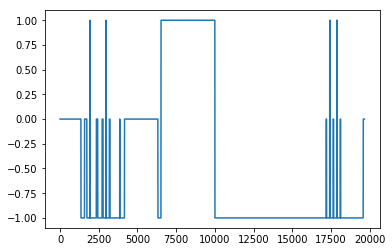

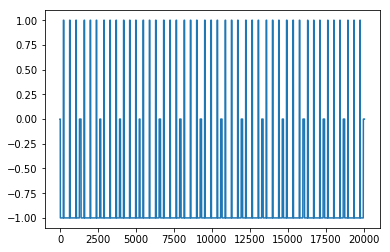

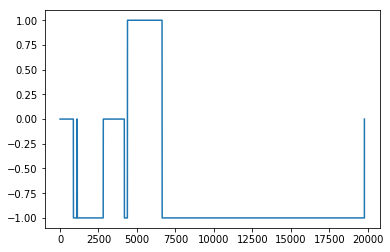

In [8]:
Yn, Ynd, keep = {}, {}, 100
for i in range(Y.shape[0]):
    Yn[i] = np.copy(Y[i][1:])
Yn = np.array([i for _,i in Yn.items()])
# print Yn.shape, Yn[0].shape, Y[0].shape
for i in range(Y.shape[0]):
    Ynd[i] = np.abs(Yn[i][1:] - Yn[i][:-1])
    print np.sum(Ynd[i]), Ynd[i].shape
    tmpind = Ynd[i] == 1
    tmpind = [range(j-keep,j+keep) for j, v in enumerate(tmpind) if v]
    tmpind = [item for sublist in tmpind for item in sublist if item < len(Ynd[i])]
#     print tmpind
    Yn[i][tmpind] = -1
    plt.figure()
    plt.plot(Yn[i])
    plt.hold
    print np.sum(Yn[i]==-1), np.sum(Yn[i]==0), np.sum(Yn[i]==1)

In [9]:
label_spreading = LabelSpreading(gamma = 20, alpha = 1, max_iter=100, tol=0.01, n_jobs=-1)
label_spreading_md = label_spreading.fit(X[1][1:,:], Yn[1][:])
predicted = label_spreading.predict(X[1])
score = label_spreading.score(X[1],Y[1]) # y_labelled = ta prohgoumena labels sou 
print score
plt.figure()
plt.hist(predicted)

MemoryError: 

In [ ]:
rng = np.random.RandomState(0)
indices = np.arange(len(x_train))
rng.shuffle(indices)

n_total_train_samples = len(y_train)
pr = 0.1 #percentages to be kept labeled
n_labeled_points =int(np.ceil(pr*len(y_train)))
#         print("Number of labeled points : %d" %n_labeled_points)

x = x_train[indices[:n_total_train_samples]] #shuffled data
y1 = y_train[indices[:n_total_train_samples]]

indices = np.arange(n_total_train_samples)  #indices previously defined have been shuffled, recompute       
unlabeled_set = indices[n_labeled_points:]
y_tr = np.copy(y1)
y_tr[unlabeled_set] = -1

In [8]:
x2 = np.copy(X[1])
y2 = np.copy(Y[1])
x3 = np.copy(X[0])
y3 = np.copy(Y[0])
x2 = x2[0: :10] ; y2 = y2[0: :10]
x3 = x3[5: :1] ; y3 = y3[5: :1]
# print(x2.shape)
x2 = np.delete(x2,[8,534,1046,1050,3116,3642,4154,4158],1)
x3 = np.delete(x3,[8,534,1046,1050,3116,3642,4154,4158],1)

In [8]:
x2 = np.copy(X[2])
y2 = np.copy(Y[2])
x3 = np.copy(X[2])
y3 = np.copy(Y[2])
x2 = x2[0: :10] ; y2 = y2[0: :10]
x3 = x3[5: :10] ; y3 = y3[5: :10]
# print(x2.shape)
x2 = np.delete(x2,[8,534,1046,1050,3116,3642,4154,4158],1)
x3 = np.delete(x3,[8,534,1046,1050,3116,3642,4154,4158],1)
# print(x2.shape)
nest = Nested_cv(n_outer_folds= 5, n_inner_folds =5, n_top=2, state = 2)
steps = [StandardScaler(), SelectKBest(), PCA(), SVC()]
params = {'feature_selection__k' : range(20,x2.shape[1],20), 'decomp__n_components':[20], 'classifier__kernel' : ['rbf'], 'classifier__C': [1], 'classifier__gamma': ['auto']}
nest.set_pipe(pip_params= params, pip_steps=steps)
nest.fit(x2,y2)

ACHTUNG! You need to use fit2 for multiple best models!


KeyboardInterrupt: 

In [15]:
# nest.print_feat_scores()
best_feat_ind = np.where(nest.get_feat_scores() >= 1)[0]
print best_feat_ind
# best_features = nest.get_best_features()
print np.array(namesf[2])[best_feat_ind]

[   2    6    7 ..., 3121 3122 4152]
['sf_meanabsslp' 'sf_rng' 'sf_wavl' ..., 'ftn_acrol0503' 'ftn_acrol0504'
 'ftn_acrol1019']


In [22]:
paramst = {'feature_selection__k' : 1000, 'decomp__n_components': 100, 'classifier__kernel' : 'rbf', 'classifier__C': 1000, 'classifier__gamma': 'auto'}
test_pip = make_pipe_clf(feature_selection= SelectKBest(), clf= SVC(),decomp= PCA(), scaler= StandardScaler())
# paramst = {'feature_selection__k' : 5000, 'decomp__n_components': 5000, 'classifier__solver': 'lbfgs', 
#            'classifier__alpha': 1e-4, 'classifier__hidden_layer_sizes': (100,100), 
#            'classifier__random_state': 1, 'classifier__verbose': True}
# test_pip = make_pipe_clf(feature_selection= SelectKBest(), clf= MLPClassifier(),decomp= PCA(), scaler= StandardScaler())

test_pip.set_params(**paramst)
test_pip.fit(x2,y2)
test_pip.score(x3,y3)
cm = confusion_matrix(y_pred=test_pip.predict(x3), y_true=y3)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm

[[ 0.26564885  0.73435115]
 [ 0.28224158  0.71775842]]


In [ ]:
pipeline2 = Pipeline([('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(k=20)) ])
#/=\/=\Sent on:
#\    / 8:15 pm
# \  /From:
#  \/ Το κυβόργιο
tsn = TSNE(n_components = 2,early_exaggeration=100, learning_rate = 800, init = 'pca' )
# x_tsn2 = PCA(n_components=30).fit_transform(x2t,y2)
spe = SpectralEmbedding(n_components = 20, affinity = 'rbf',gamma = 1e-3)
# spe1 = SpectralEmbedding(n_components = 10, affinity = 'rbf',gamma = 1e-2)

x2t = pipeline2.fit_transform(x2,y2)
x0t = pipeline2.transform(x0)
x1t = pipeline2.transform(x1)

# X_tsn2 = vis_clf.fit_transform(x2t)
X_spe0 = spe.fit_transform(x0t)
X_spe1 = spe.fit_transform(x1t)
X_spe2 = spe.fit_transform(x2t)

# plt.plot(X_mds[0],X_mds[1])
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.scatter(X_spe1[:,0], X_spe1[:,1], c = y1, alpha = 0.3)
plt.subplot(1,3,2)
plt.scatter(X_spe2[:,0], X_spe2[:,1], c = y2, alpha = 0.3)
plt.subplot(1,3,3)
plt.scatter(X_spe0[:,0], X_spe0[:,1], c = y0, alpha = 0.3)

In [8]:
# stepst = [StandardScaler(), SelectKBest(), PCA(), SVC()]
paramst = {'feature_selection__k' : 2000, 'decomp__n_components': 20, 'classifier__kernel' : 'rbf', 'classifier__C': 100, 'classifier__gamma': 'auto'}
test_pip = make_pipe_clf(feature_selection= SelectKBest(), clf= SVC(),decomp= PCA(), scaler= StandardScaler())
test_pip.set_params(**paramst)
test_pip.fit(x2,y2)
test_pip.score(x3,y3)
cm = confusion_matrix(y_pred=test_pip.predict(x3), y_true=y3)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm

[[ 0.249499  0.750501]
 [ 0.        1.      ]]


In [89]:
temp_pip = make_pipe(feature_selection=SelectKBest(), decomp = PCA(), scaler = StandardScaler(), order = 1)
temp_params =  {'feature_selection__k' : 750, 'decomp__n_components': 50 }
temp_pip.set_params(**temp_params)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=750, score_func=<function f_classif at 0x7f5c3b19e2a8>)), ('decomp', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [92]:
xtemp1 = np.delete(X[2],[8,534,1046,1050,3116,3642,4154,4158],1)
print xtemp1.shape
xtemp = temp_pip.fit_transform(xtemp1,Y[2])
xtemp2 = np.delete(X[1],[8,534,1046,1050,3116,3642,4154,4158],1)
print xtemp2.shape
xtempt2 = temp_pip.transform(xtemp2)
xtemp3 = np.delete(X[0],[8,534,1046,1050,3116,3642,4154,4158],1)
print xtemp3.shape
xtempt3 = temp_pip.transform(xtemp3)

(19874, 6208)
(20057, 6208)
(19782, 6208)


In [99]:
# xnew = np.copy(xtemp)
xn, yn = time_form(xtemp,Y[2],0,0)
xnt2 , ynt2 = time_form(xtempt2,Y[1],0,0)
xnt3 , ynt3 = time_form(xtempt3,Y[0],0,0)
# xn = np.concatenate((xnew[:-3,:],xnew[1:-2,:],xnew[2:-1,:],xnew[3:,:]),axis = 1)

In [101]:
xn.shape

(19874, 50)

In [100]:
clf = SVC(kernel='rbf',C=1)
clf.fit(xn,yn)
print clf.score(xnt2,ynt2)
print clf.score(xnt3,ynt3)

0.894351099367
0.923566878981


In [82]:
c1 = clf.predict(xn)
c2 = clf.predict(xnt3)

In [69]:
xtemp2 = np.delete(X[1],[8,534,1046,1050,3116,3642,4154,4158],1)
xtemp = temp_pip.transform(xtemp2)

In [70]:
xnew = np.copy(xtemp)
xn = np.concatenate((xnew[:-3,:],xnew[1:-2,:],xnew[2:-1,:],xnew[3:,:]),axis = 1)

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(
#     xn, Y[1][3:], test_size=0.33, random_state=42)
slcp = int(round(0.7*len(xn)))
X_train, y_train = xn[:slcp,:], Y[2][3:3+slcp]
X_test, y_test = xn[slcp:], Y[2][3+slcp:]

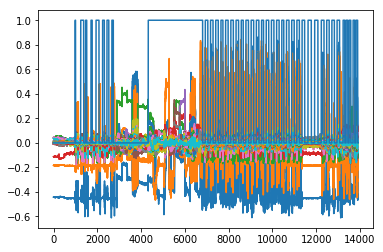

In [13]:
plt.plot(normalize(X_train))
plt.hold
plt.plot(y_train)

In [14]:
clf = SVC(kernel='rbf',C=1)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.75977185036067774

In [83]:
print(classification_report(y_pred=c1, y_true=yn))
print(classification_report(y_pred=c2, y_true=ynt3))

             precision    recall  f1-score   support

        0.0       0.69      0.42      0.53     10180
        1.0       0.57      0.80      0.67      9691

avg / total       0.63      0.61      0.59     19871

             precision    recall  f1-score   support

        0.0       0.40      0.17      0.24     10482
        1.0       0.43      0.71      0.54      9297

avg / total       0.42      0.43      0.38     19779



In [84]:
cm = confusion_matrix(y_pred=c1, y_true=yn)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
cm = confusion_matrix(y_pred=c2, y_true=ynt3)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm

[[ 0.42416503  0.57583497]
 [ 0.19853472  0.80146528]]
[[ 0.1743942   0.8256058 ]
 [ 0.28955577  0.71044423]]
